<a href="https://colab.research.google.com/github/AveryHsieh/Machine-Learning/blob/main/TextMining-News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **文字探勘_真假新聞預測**

Fake and real news dataset

資料來源:https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/data


##載入函式庫（libraries）

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

##導入data set

連接Google Drive，並使用read_csv()函數導入CSV格式的數據集


In [ ]:
#連接Google雲端硬碟
from google.colab import drive
drive.mount('/content/drive')

#將真假新聞的資料分別存進true和false
true = pd.read_csv("/content/drive/MyDrive/112-1/ML/Data/fake-and-real-news-dataset/True.csv")
false = pd.read_csv("/content/drive/MyDrive/112-1/ML/Data/fake-and-real-news-dataset/Fake.csv")

#這兩個資料集包含約 40000 篇文章，其中有假新聞也有真實新聞。假新聞和真實新聞的數據分別存在兩個獨立的數據集中，每個數據集各包含約 20000 篇文章。

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##數據視覺化和預處理
##Data Visualization and Preprocessing
數據視覺化和預處理是進行數據分析和機器學習的重要步驟。在開始建模之前，需要對數據進行探索性分析（Exploratory Data Analysis，EDA），包括數據視覺化以了解其分佈、相關性和特徵之間的關係。同時，也需要進行數據預處理，包括處理缺失值、標準化數據、處理類別特徵等。

In [ ]:
#看真實新聞的前5項
true.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [ ]:
#看假新聞的前5項
false.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [ ]:
#將true和false數據的category列設置為1和0，這是一個binary標籤，表示新聞是真實的（1）還是虛假的（0）。
true['category'] = 1
false['category'] = 0
df = pd.concat([true,false]) #合併兩個datasets

<Axes: xlabel='category', ylabel='count'>

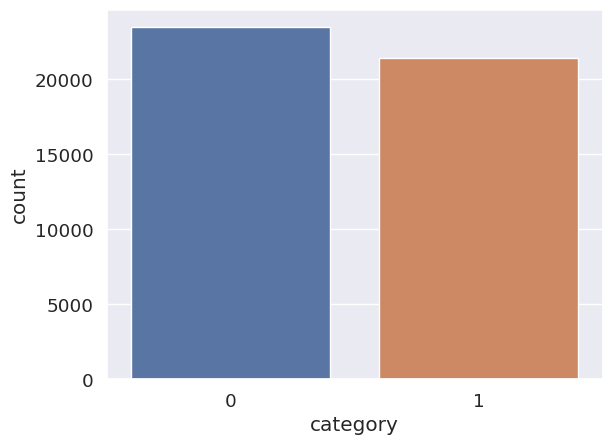

In [ ]:
#設定Seaborn圖表的風格為深色網格風格。
sns.set_style("darkgrid")
#使用Seaborn繪製了一個計數圖，顯示真實新聞（1）和虛假新聞（0）的數量，可以看到資料集數量是平衡的
sns.countplot(x=df.category,data=df)

In [ ]:
#看df的前五項
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  category  
0  December 31, 2017          1  
1  December 29, 2017          1  
2  December 31, 2017          1  
3  December 30, 2017          1  
4  December 29, 2017          1

In [ ]:
#檢查有沒有NA值
df.isna().sum() # Checking for nan Values

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [ ]:
#計算並顯示'title'列中非缺失（非空）值的數量
df.title.count()

44898

In [ ]:
#計算並顯示'subject'列中每個Unique值的出現次數，以Series形式返回
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'Government News'),
 Text(5, 0, 'left-news'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

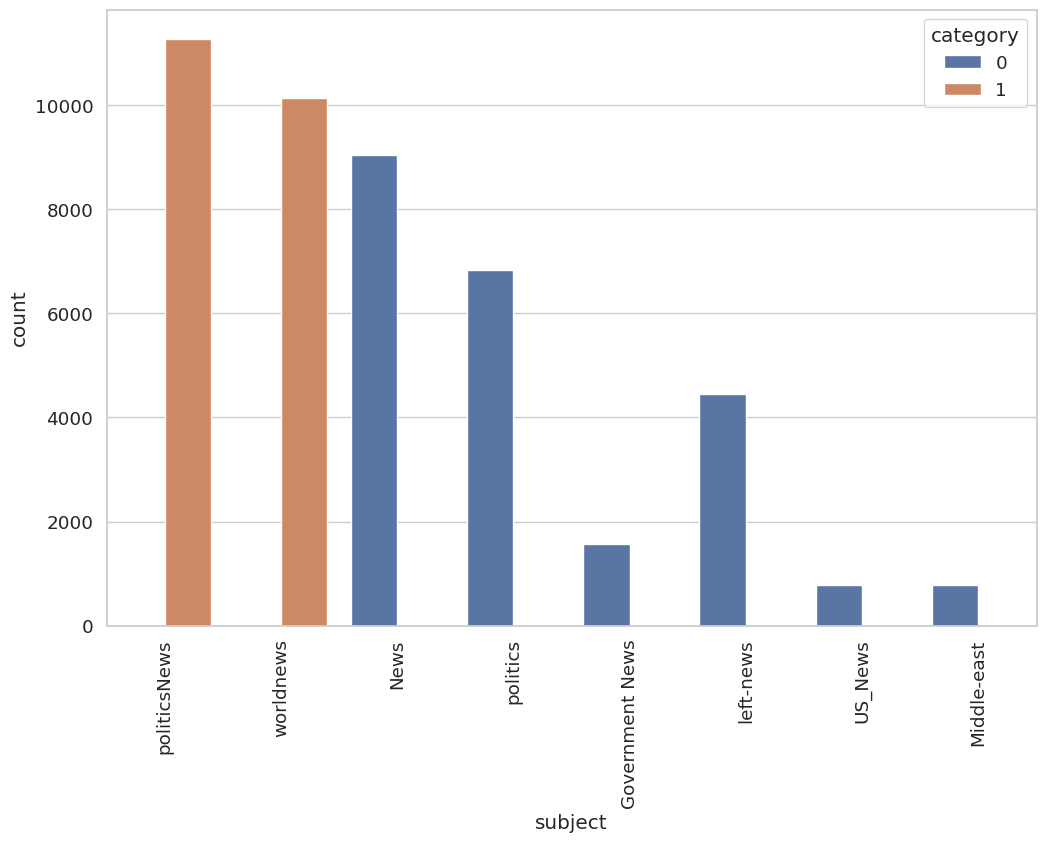

In [ ]:
#設置圖表的大小為12x8英寸
plt.figure(figsize = (12,8))
#設置Seaborn圖表的風格為白色網格，並設置字體比例為1.2
sns.set(style = "whitegrid",font_scale = 1.2)
#繪製一個帶有兩個分組條形的計數圖，橫軸是'subject'列的Unique值，顏色區分為'category'列的不同類別
#數據來自於DataFrame 'df'
chart = sns.countplot(x = "subject", hue = "category" , data = df)
#將x軸的標籤文字旋轉90度，以避免文字重疊
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

In [ ]:
#合併 'text' 列和 'title' 列，並將結果存回 'text' 列中
df['text'] = df['text'] + " " + df['title']
#刪除 'title'、'subject' 和 'date' 這三列，讓DataFrame中就只剩下 'text' 這一列的資料。這樣的操作通常是為了簡化數據集，只保留需要的特徵，以便進行後續的分析或建模工作。
del df['title']
del df['subject']
del df['date']

In [ ]:
#創建一個包含英文停用詞和標點符號的集合，停用詞是在文本處理中被視為無意義單詞，通常會被過濾掉以提高文本處理的效率(因為它們通常不包含有用的信息，或者在文本分析的上下文中不具有特殊意義)
#集合的建立主要是為了在文本處理過程中，將無意義的詞語和符號過濾掉，以保留有意義的內容。

#從nltk下載並載入英文停用詞（stopwords）集合
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))

#載入標點符號，將標點符號轉換為一個列表
punctuation = list(string.punctuation)

#將標點符號加入到停用詞集合中，這樣在文本處理時，這些標點符號也會被視為無意義的停用詞而被過濾掉
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#對DataFrame中的'text'列進行文本預處理

#定義一個函數strip_html，用於移除HTML標籤
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#定義一個函數remove_between_square_brackets，用於移除方括號內的內容
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#定義一個函數remove_between_square_brackets，用於移除文本中的URL
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

#定義一個函數remove_stopwords，用於移除文本中的停用詞
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#定義一個函數denoise_text，將文本應用於以上的預處理步驟，移除HTML標籤、方括號內容、URL和停用詞
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

#對'text'列中的文本套用denoise_text函數，對全部文本進行預處理
df['text']=df['text'].apply(denoise_text)

<ipython-input-37-1e0d138a3131>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


##**視覺化**
###1.文字雲

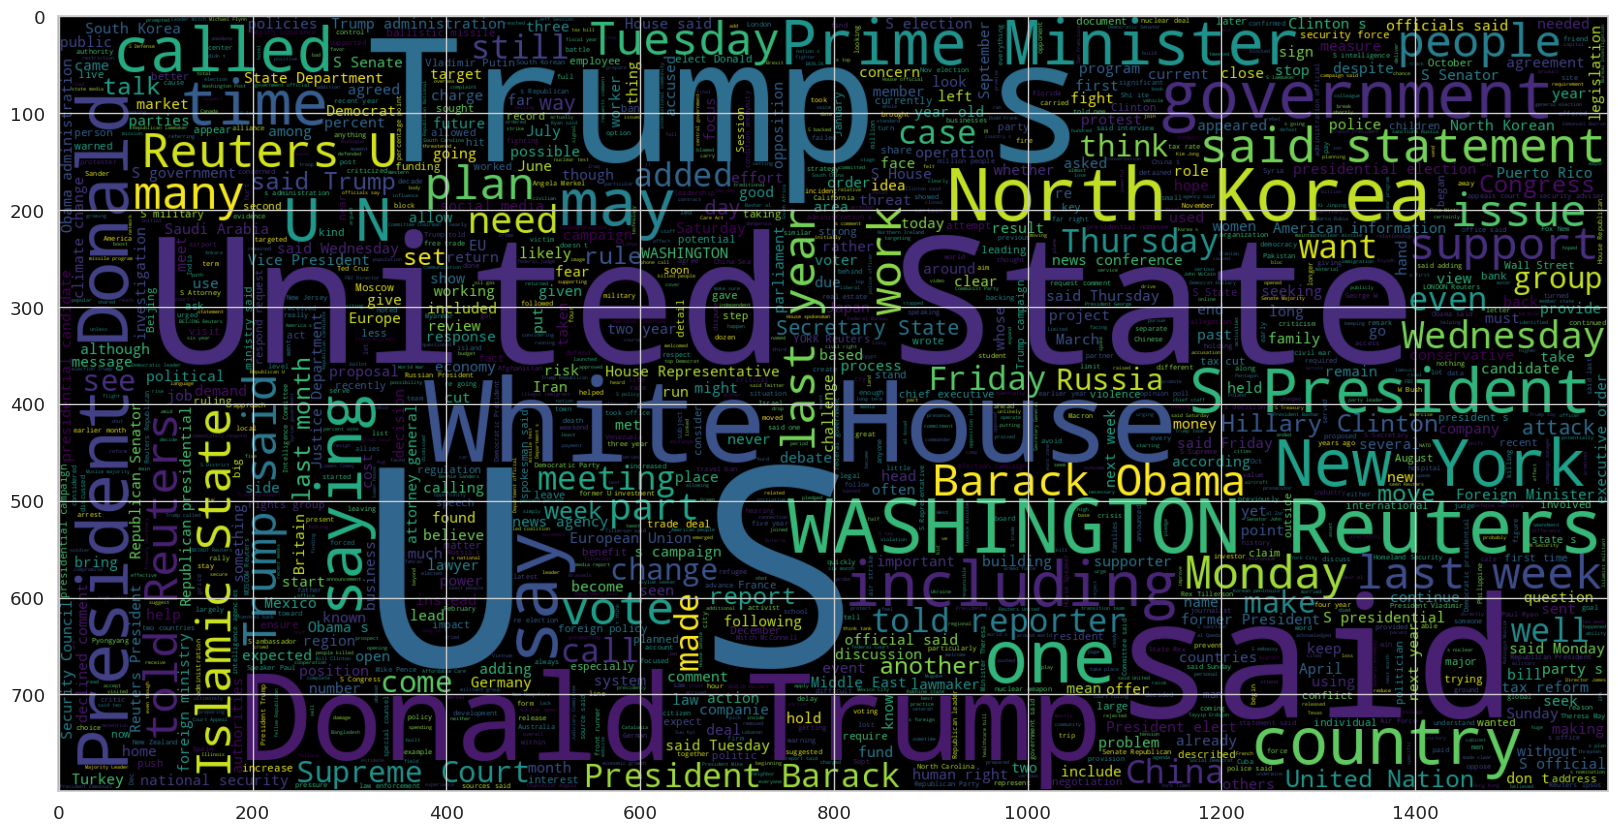

In [ ]:
#將真實新聞的資料做成文字雲(Word Cloud)
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

#使用WordCloud函式庫生成文字雲，文字雲顯示了真實新聞的文本內容
#文字雲中的單詞出現頻率越高，其在圖中的大小就越大，這種視覺化方式可以幫助我們直觀地了解真實新聞中哪些單詞出現得比較頻繁。

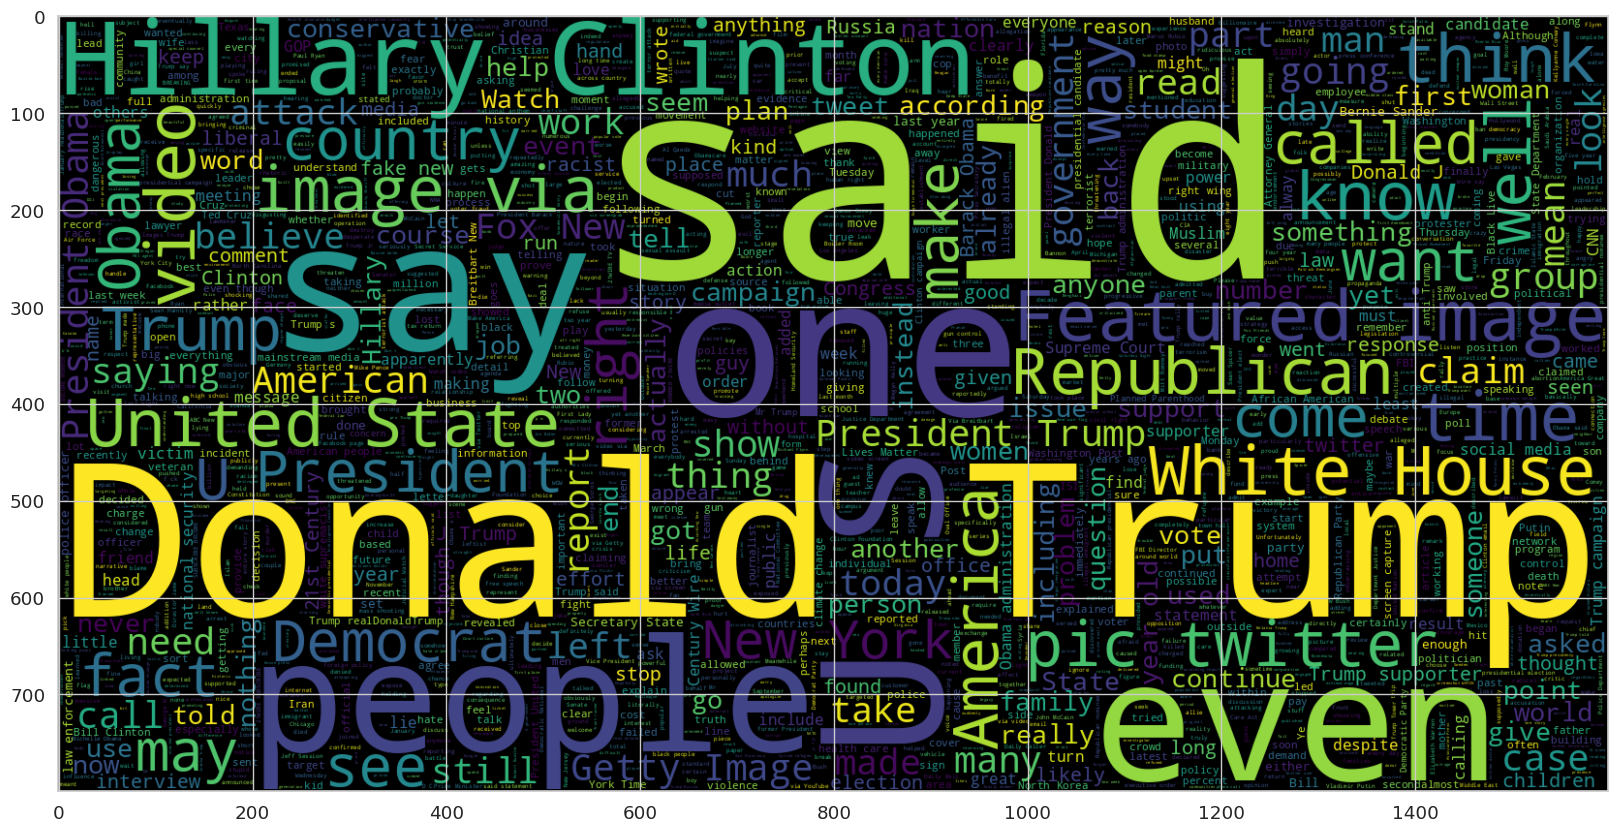

In [ ]:
#將假新聞的資料做成文字雲(Word Cloud)
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')
#使用WordCloud函式庫生成文字雲，文字雲顯示了假新聞的文本內容
#文字雲中的單詞出現頻率越高，其在圖中的大小就越大，這種視覺化方式可以幫助我們直觀地了解假新聞中哪些單詞出現得比較頻繁。

###2.長條圖

> *文字數量分布情況* : 以長條圖顯示真實新聞和虛假新聞的文本字符長度分佈情況



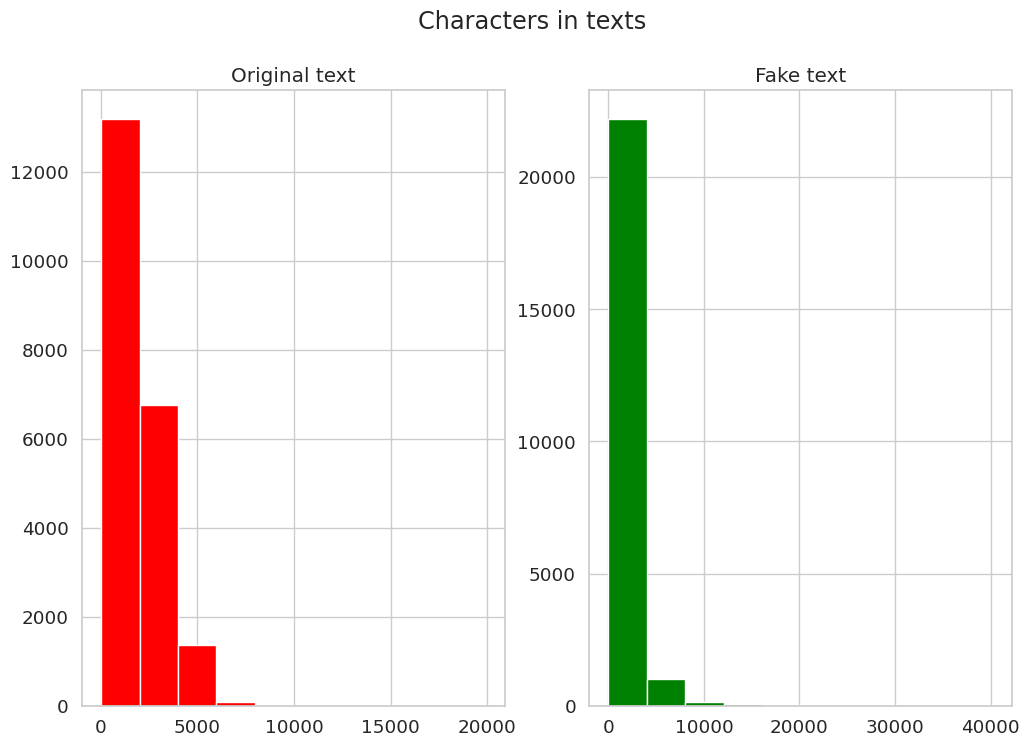

In [ ]:
#創建一個包含兩個子圖的畫布，每個子圖的大小為12x8英寸
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

#獲取真實新聞文本的字符長度，並在第一個子圖(ax1)中繪製直方圖，顏色設為紅色
text_len=df[df['category']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Original text')#設定子圖標題為'Original text'

#獲取假新聞文本的字符長度，並在第二個子圖(ax2)中繪製直方圖，顏色設為綠色
text_len=df[df['category']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text') #設定子圖標題為'Fake text'

#設定整個圖的標題為'Characters in texts'，並顯示畫布
fig.suptitle('Characters in texts')
plt.show()

##可以看出兩者的分布有點不同
#真實新聞文本的分佈中，大約2500個字符的文本是最常見的，而在假新聞文本的分佈中，大約5000個字符的文本是最常見的。這種差異可能反映了真實新聞和假新聞的寫作風格或者信息傳遞方式上的差異。
#這樣的視覺化分析可以幫助我們快速了解不同類型文本的特點，同時也有助於進一步的文本分類或分析工作。

> *文字數量分布情況* : 以長條圖顯示真實新聞和虛假新聞的文本的詞數分佈情況

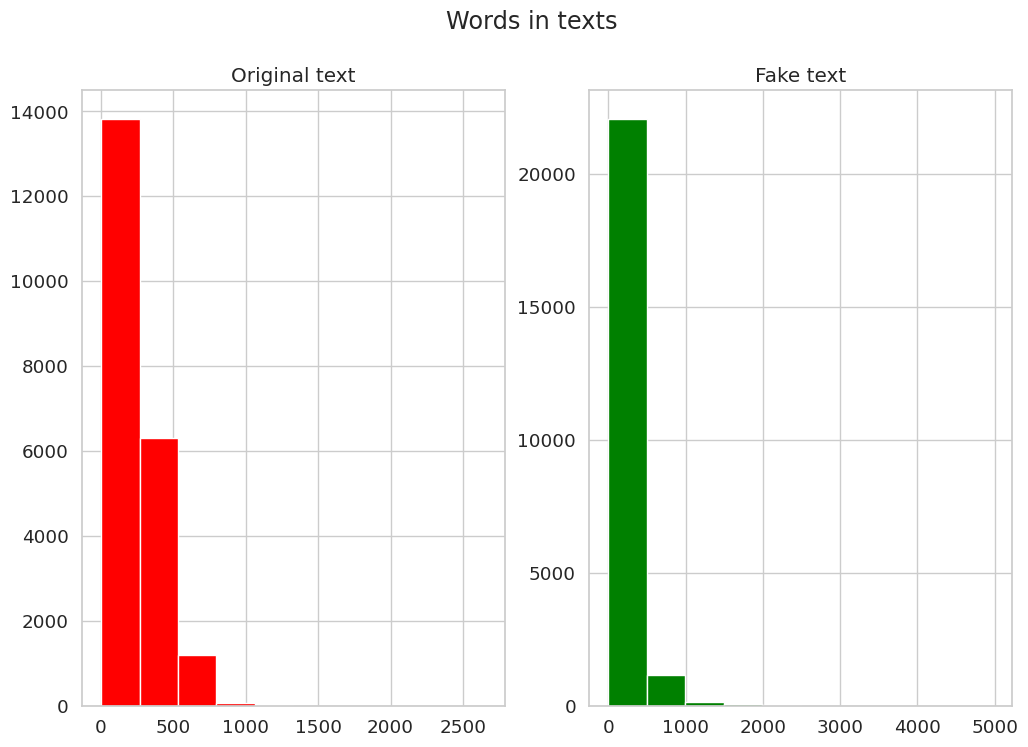

In [ ]:
#創建一個包含兩個子圖的畫布，每個子圖的大小為12x8英寸
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

#獲取真實新聞文本的詞數，將文本按空格分割成單詞，計算單詞數目，並在第一個子圖(ax1)中繪製直方圖，顏色設為紅色
text_len=df[df['category']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Original text')

#獲取虛假新聞文本的詞數，將文本按空格分割成單詞，計算單詞數目，並在第二個子圖(ax2)中繪製直方圖，顏色設為綠色
text_len=df[df['category']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')

#設定整個圖的標題為'Words in texts'，並顯示畫布
fig.suptitle('Words in texts')
plt.show()

> *單詞平均長度分布情況* : 以長條圖比較真實新聞和虛假新聞中單詞平均長度的分佈情況

<ipython-input-42-f1a7d24ef9eb>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-42-f1a7d24ef9eb>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level 

Text(0.5, 0.98, 'Average word length in each text')

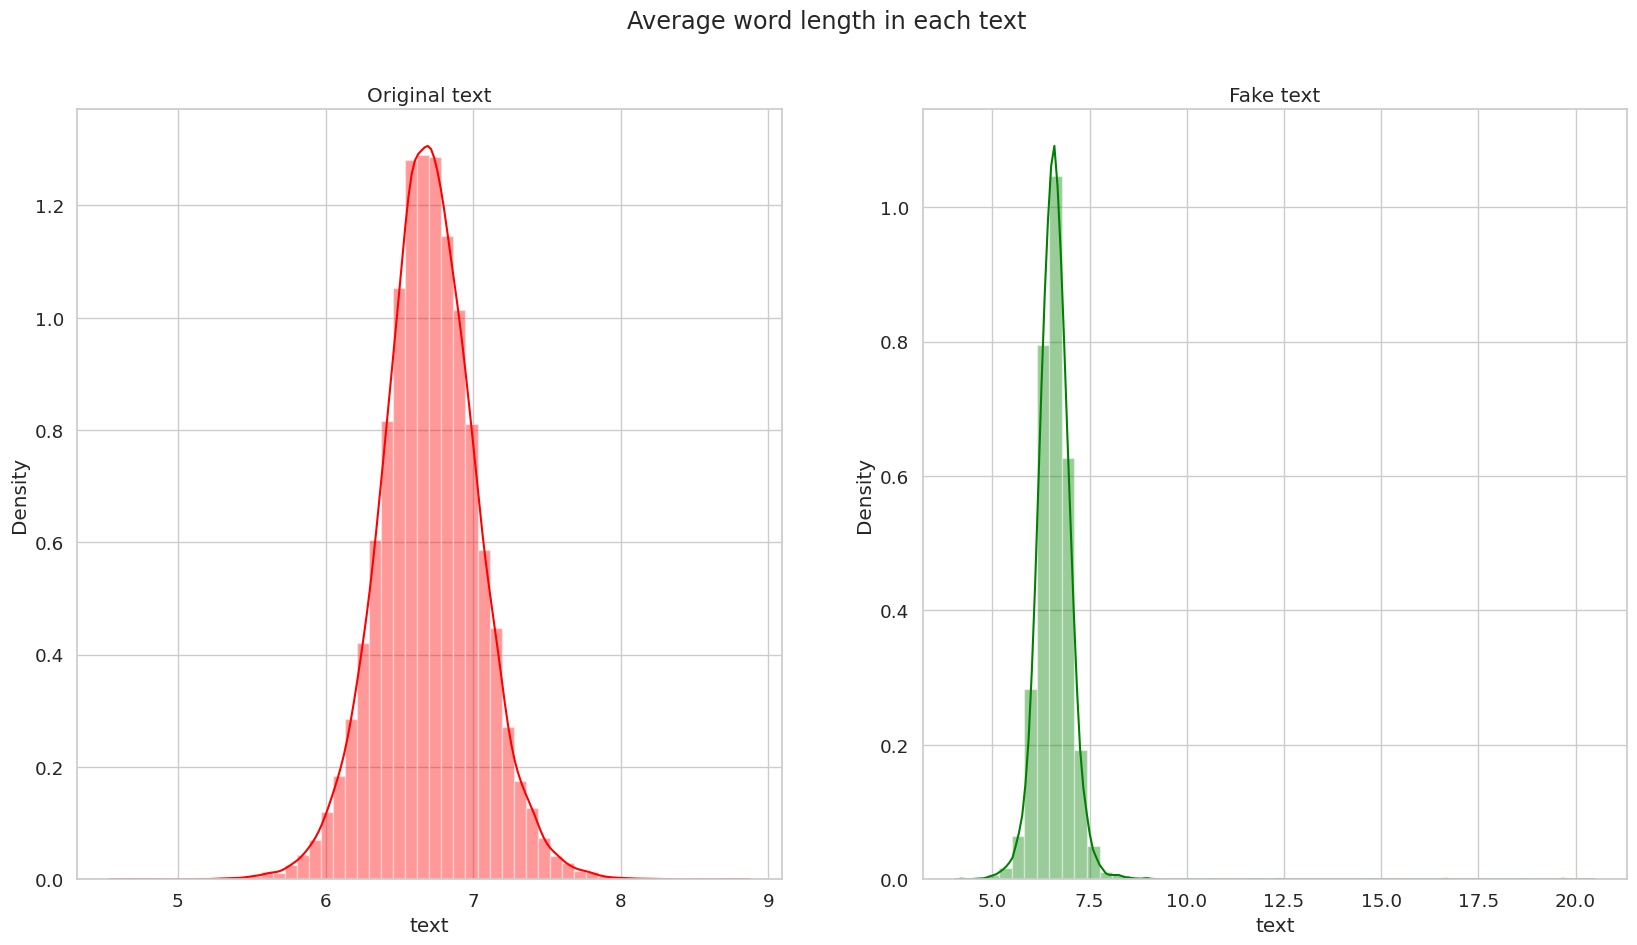

In [ ]:
#創建一個包含兩個子圖的畫布，每個子圖的大小為20x10英寸
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))

#獲取真實新聞文本中每個單詞的長度，並繪製平均長度的分佈圖，顏色設為紅色，顯示在第一個子圖(ax1)中
word=df[df['category']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Original text')

#獲取虛假新聞文本中每個單詞的長度，並繪製平均長度的分佈圖，顏色設為綠色，顯示在第二個子圖(ax2)中
word=df[df['category']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake text')

#設定整個圖的標題為'Average word length in each text'，並顯示畫布
fig.suptitle('Average word length in each text')

###3.條形圖

> *詞頻* : 以條形圖顯示文本中出現頻率最高的前10個單詞。

函式及套件設定

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)
corpus[:5]

from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

繪製詞頻條形圖

字元分析 - Unigram Analysis :以條形圖呈現前十個最常出現的一元單字

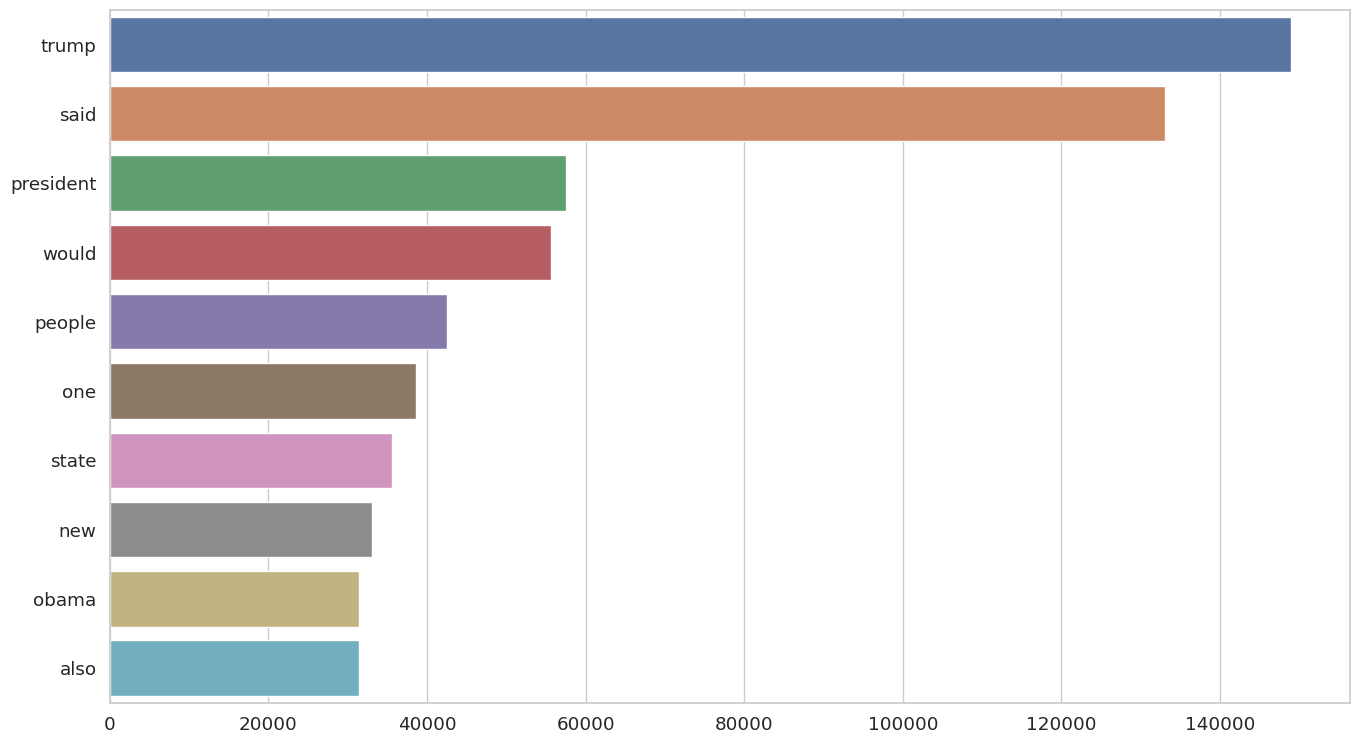

In [ ]:
#設定畫布大小為16x9英寸
plt.figure(figsize = (16,9))

#使用get_top_text_ngrams函數提取文本中的前10個單詞及其出現次數，N元為1（單詞）
most_common_uni = get_top_text_ngrams(df.text,10,1)

#將提取的前10個單詞及其出現次數轉換為字典形式
most_common_uni = dict(most_common_uni)

#使用Seaborn的barplot函數繪製條形圖，x軸為單詞的出現次數，y軸為單詞本身
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

#顯示條形圖
plt.show()

字元分析 - Bigram Analysis :以條形圖呈現前十個最常出現的二元單字

<Axes: >

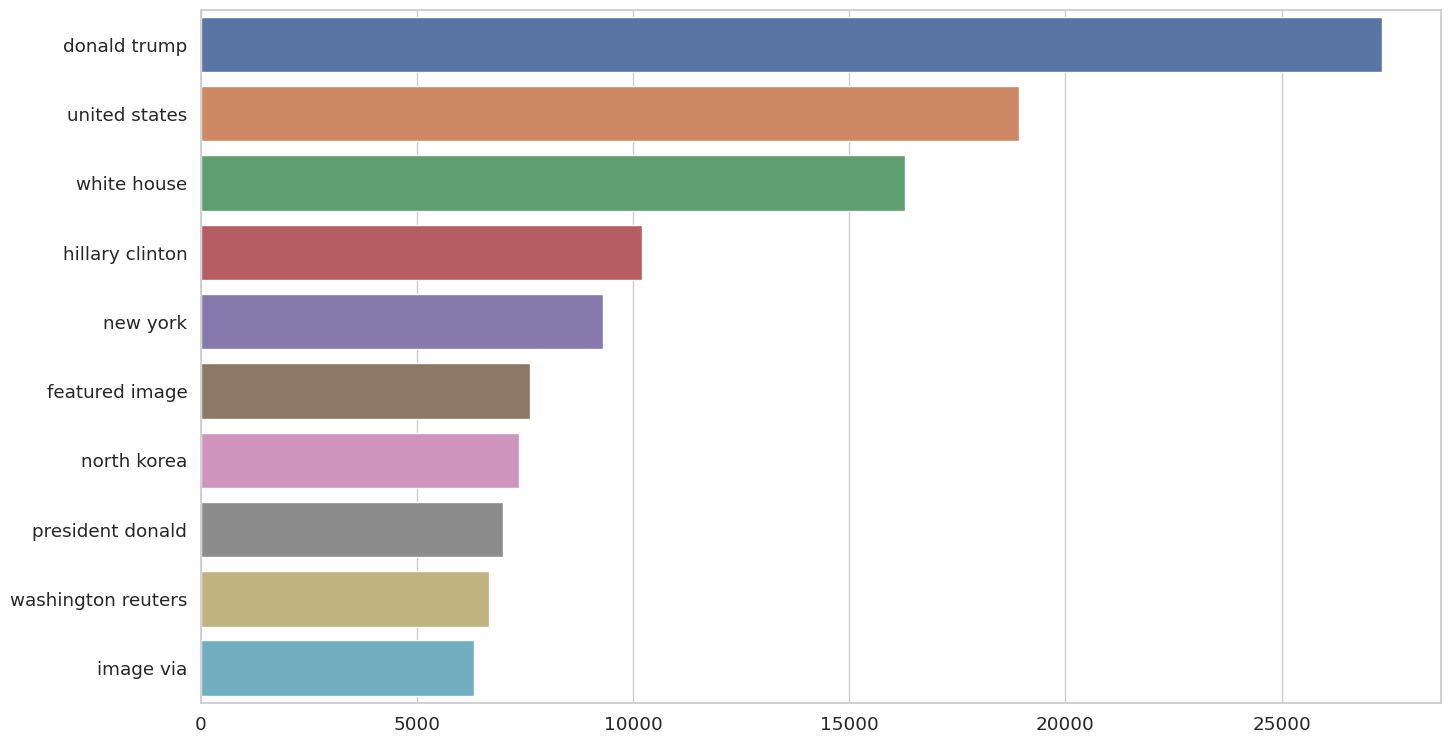

In [ ]:
#與上一個cell做的事情差不多，只是get_top_text_ngrams()函數中ngram的參數值改設為2
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

字元分析 - Trigram Analysis :以條形圖呈現前十個最常出現的三元單字

<Axes: >

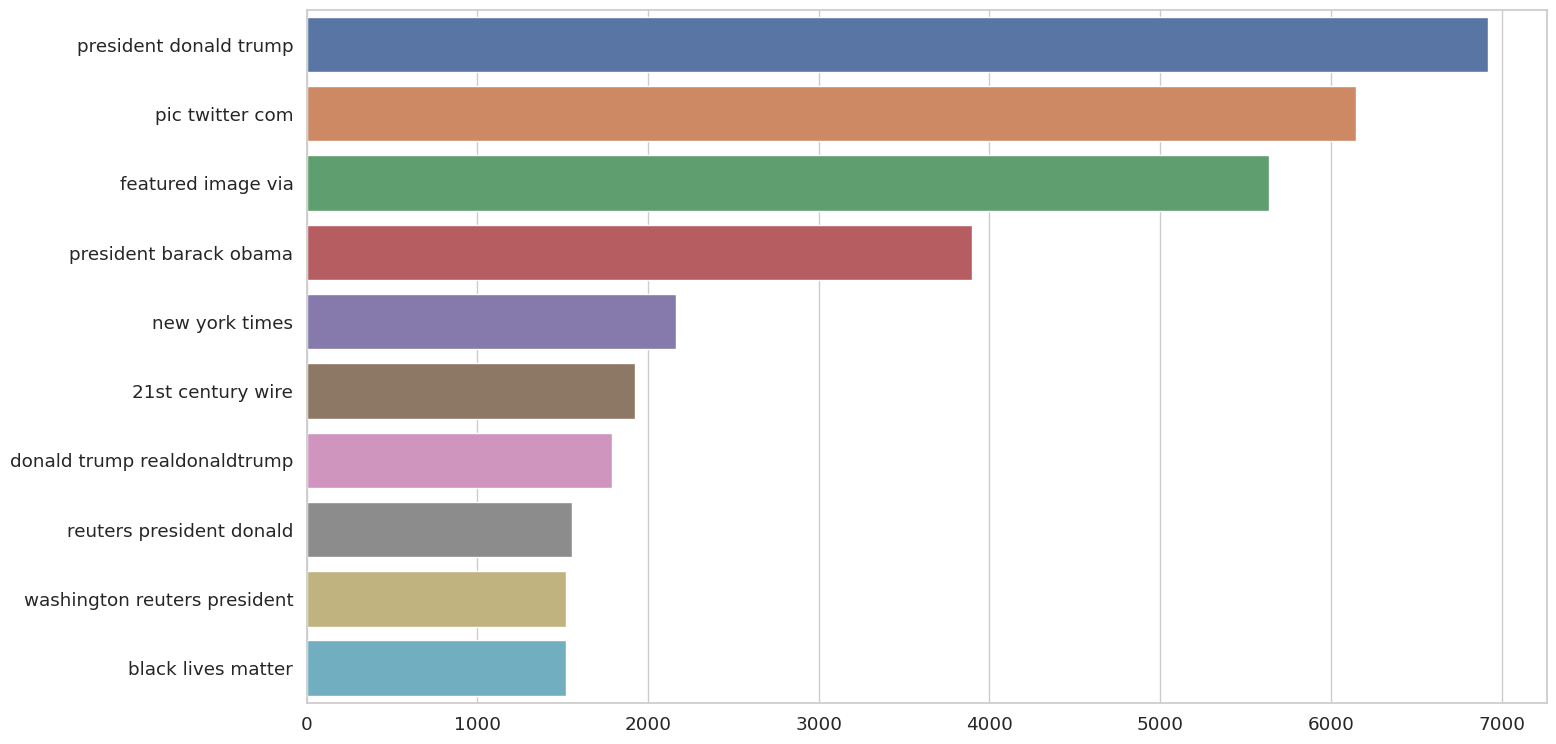

In [ ]:
#與上一個cell做的事情差不多，只是get_top_text_ngrams()函數中ngram的參數值改設為3
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

##訓練

In [ ]:
#將資料分為訓練集和測試集
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)

進行文本數據的前處理，將文本轉換為數字序列和進行序列填充（padding）

目的是將文本數據轉換為神經網絡可以處理的格式，以便進行自然語言處理（NLP）任務，例如文本分類、情感分析等。這樣的預處理過程是為了確保模型能夠處理固定長度的輸入數據。

In [ ]:
#設定最大特徵數，即在文本中選擇最常見的前10000個詞彙
max_features = 10000
#設定文本的最大長度為300個詞彙
maxlen = 300

#使用Keras的Tokenizer類，將文本轉換為數字序列
tokenizer = text.Tokenizer(num_words=max_features)

#使用訓練數據（x_train）來構建詞彙索引，建立詞彙字典
tokenizer.fit_on_texts(x_train)

#將訓練數據轉換為數字序列，每個詞彙被對應到詞彙字典中的整數
tokenized_train = tokenizer.texts_to_sequences(x_train)

#進行序列填充，確保所有數字序列的長度都是300個詞彙
#如果超過300詞彙，進行截斷；不足300詞彙，則在序列的前面填充0
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

#將測試數據轉換為數字序列，並進行序列填充，保持與訓練數據相同的長度
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

使用預訓練的詞向量（word embeddings）建立一個嵌入矩陣（embedding matrix）。

該嵌入矩陣將被用作神經網絡模型的詞嵌入層，提供預訓練的詞向量作為輸入。

In [ ]:
#指定預訓練詞向量的文件路徑
EMBEDDING_FILE = "/content/drive/MyDrive/112-1/機器學習觀念與應用/練習一/glove.twitter.27B.100d.txt"

#定義函數，解析預訓練詞向量文件的每一行，將單詞和詞向量轉換為字典形式
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

# 使用上述函數解析預訓練詞向量文件，得到包含單詞及對應詞向量的字典
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

#將所有詞向量堆疊成一個NumPy數組
all_embs = np.stack(embeddings_index.values())
# 計算詞向量的均值和標準差
emb_mean,emb_std = all_embs.mean(), all_embs.std()
#獲取每個詞向量的維度大小
embed_size = all_embs.shape[1]

#獲取Tokenizer對象建立的單詞索引
word_index = tokenizer.word_index
#確定需要處理的詞彙數量，限制在max_features和實際文本中出現的詞彙數量之間
nb_words = min(max_features, len(word_index))

#創建一個初始的嵌入矩陣，使用隨機生成的數值
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

#遍歷文本的詞彙索引，將在預訓練詞向量中找到的詞向量放入嵌入矩陣中
#如果某個單詞不在預訓練詞向量中，則保持隨機生成的數值
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


設定訓練參數

In [ ]:
#每個訓練批次中的樣本數量，影響每次參數更新的數據量
batch_size = 256
#完整遍歷訓練數據的次數，即訓練的輪數
epochs = 10
#詞向量的維度，決定了每個詞彙在嵌入矩陣中的表示維度
embed_size = 100


#定義學習率的調整策略
#ReduceLROnPlateau 是一個回調函數，根據模型的驗證準確度調整學習率
#當驗證準確度在兩個連續的 epoch 中都沒有改善時，將學習率減少到原來的一半
#min_lr 指定學習率的下限值，避免學習率過小
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',  # 監控驗證準確度
    patience=2,               # 在多少個 epoch 內沒有改善時進行調整
    verbose=1,                # 顯示調整學習率的相關信息
    factor=0.5,               # 學習率減少的因數，減少為原來的一半
    min_lr=0.00001            # 學習率的下限值
)

**TRAINING THE MODEL**

In [ ]:
#定義RNN神經網絡模型

model = Sequential()
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

#這段程式碼定義了一個基於LSTM的神經網絡模型。
#模型包括了一個嵌入層，兩個LSTM層，一個全連接層和一個輸出層。
#嵌入層使用了預訓練的詞向量作為輸入，LSTM層負責捕捉文本的時間序列特徵，全連接層進行特徵提取，輸出層則經過Sigmoid激活函數用於二元分類。
#最後，使用Adam優化器進行模型的編譯。

In [ ]:
model.summary() #顯示神經網絡模型的摘要信息，包括每一層的名稱、輸入形狀、輸出形狀以及參數數量等。

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 300, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1168769 (4.46 MB)
Trainable params: 168769 (659.25 KB)
Non-trainable params: 1000000 (3.81 MB)
_________________________________________________________________


In [ ]:
#訓練神經網絡模型
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
132/132 [==============================] - 355s 3s/step - loss: 0.2010 - accuracy: 0.9155 - val_loss: 0.0835 - val_accuracy: 0.9691 - lr: 0.0010
Epoch 2/10
132/132 [==============================] - 347s 3s/step - loss: 0.0857 - accuracy: 0.9687 - val_loss: 0.0493 - val_accuracy: 0.9843 - lr: 0.0010
Epoch 3/10
132/132 [==============================] - 347s 3s/step - loss: 0.0524 - accuracy: 0.9810 - val_loss: 0.0512 - val_accuracy: 0.9822 - lr: 0.0010
Epoch 4/10
132/132 [==============================] - 343s 3s/step - loss: 0.0423 - accuracy: 0.9851 - val_loss: 0.0243 - val_accuracy: 0.9927 - lr: 0.0010
Epoch 5/10
132/132 [==============================] - 344s 3s/step - loss: 0.0403 - accuracy: 0.9857 - val_loss: 0.0375 - val_accuracy: 0.9881 - lr: 0.0010
Epoch 6/10
132/132 [==============================] - ETA: 0s - loss: 0.0368 - accuracy: 0.9871
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
132/132 [==============================] - 344s 

**ANALYSIS AFTER TRAINING OF MODEL**

In [ ]:
#計算並輸出訓練和測試數據上的模型準確度
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 171s 162ms/step - loss: 0.0065 - accuracy: 0.9978
Accuracy of the model on Training Data is -  99.78023767471313 %
351/351 [==============================] - 57s 163ms/step - loss: 0.0129 - accuracy: 0.9965
Accuracy of the model on Testing Data is -  99.65255856513977 %


繪製訓練和測試過程中的準確度和損失值

總共有兩張圖，第一個子圖顯示了訓練和測試準確度的變化，第二個子圖顯示了訓練和測試損失值的變化。每個子圖的x軸表示epochs的次數，y軸表示準確度（Accuracy）或損失值（Loss）。不同的線條和顏色分別代表了訓練和測試的數據。這樣的圖形可以幫助我們了解模型在訓練過程中的表現情況。

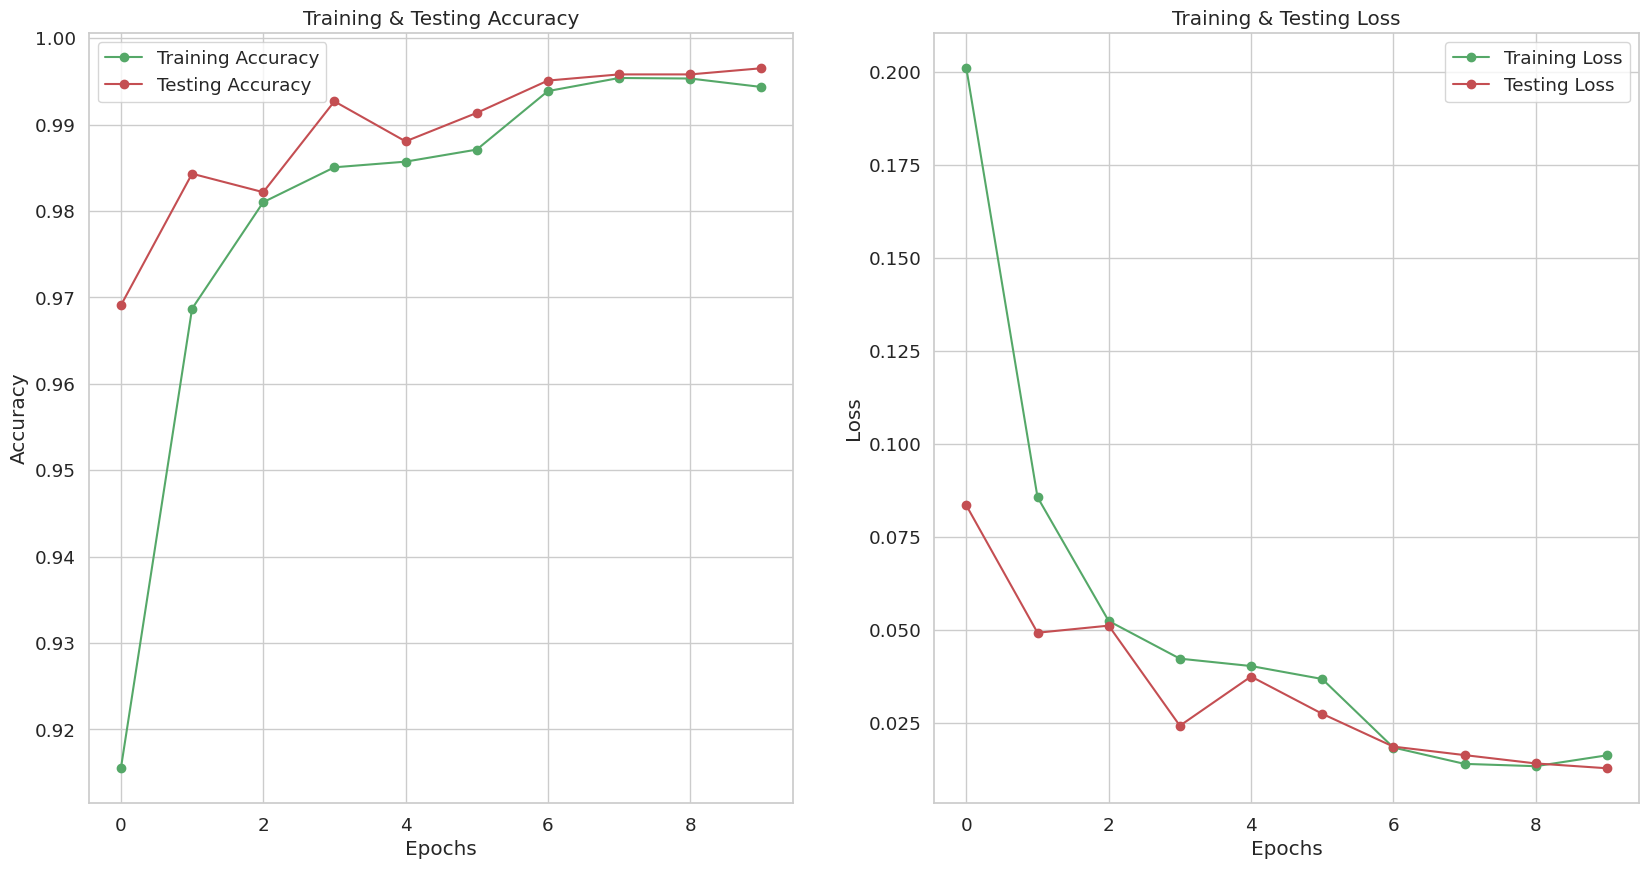

In [ ]:
#定義一個包含0到9的列表，表示訓練過程中的epochs次數
epochs = [i for i in range(10)]

#創建一個具有1行2列的子圖形佈局
fig, ax = plt.subplots(1, 2)

#從訓練歷史（history）中提取訓練和驗證數據的準確度和損失值
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

#設定圖形的尺寸
fig.set_size_inches(20, 10)

#在第一個子圖中繪製訓練和驗證準確度
ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')  #設定標題
ax[0].legend()  #顯示圖例
ax[0].set_xlabel("Epochs")  #設定x軸標籤
ax[0].set_ylabel("Accuracy")  #設定y軸標籤

#在第二個子圖中繪製訓練和驗證損失值
ax[1].plot(epochs, train_loss, 'go-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label='Testing Loss')
ax[1].set_title('Training & Testing Loss')  #設定標題
ax[1].legend()  #顯示圖例
ax[1].set_xlabel("Epochs")  #設定x軸標籤
ax[1].set_ylabel("Loss")  #設定y軸標籤

#顯示圖形
plt.show()

In [ ]:
#用模型對測試數據進行預測，並將預測結果儲存在 pred 變數中，快速查看模型對於測試數據的預測結果，了解模型的表現。

pred = model.predict(X_test)

threshold = 0.5
pred_classes = (pred > threshold).astype(int)

print(pred_classes[:5])

351/351 [==============================] - 59s 164ms/step
[[0]
 [0]
 [0]
 [0]
 [1]]


In [ ]:
#用 sklearn.metrics 套件內的 classification_report 函數計算並顯示每個類別的精確度、召回率、F1-分數和支持數。
#這提供了對模型性能的更詳細和全面的了解。通常用於評估模型的分類性能，並且顯示模型在每個類別上的表現。

pred_classes = (pred > threshold).astype(int)

# 使用 classification_report 函數
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_classes, target_names=['Fake', 'Not Fake']))

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      5858
    Not Fake       0.99      1.00      1.00      5367

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [ ]:
#計算混淆矩陣(confusion matrix)
cm = confusion_matrix(y_test,pred_classes)
cm

array([[5829,   29],
       [  10, 5357]])

In [ ]:
#創建一個 Pandas DataFrame，用於更清晰地顯示混淆矩陣的結果
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(88.25, 0.5, 'Actual')

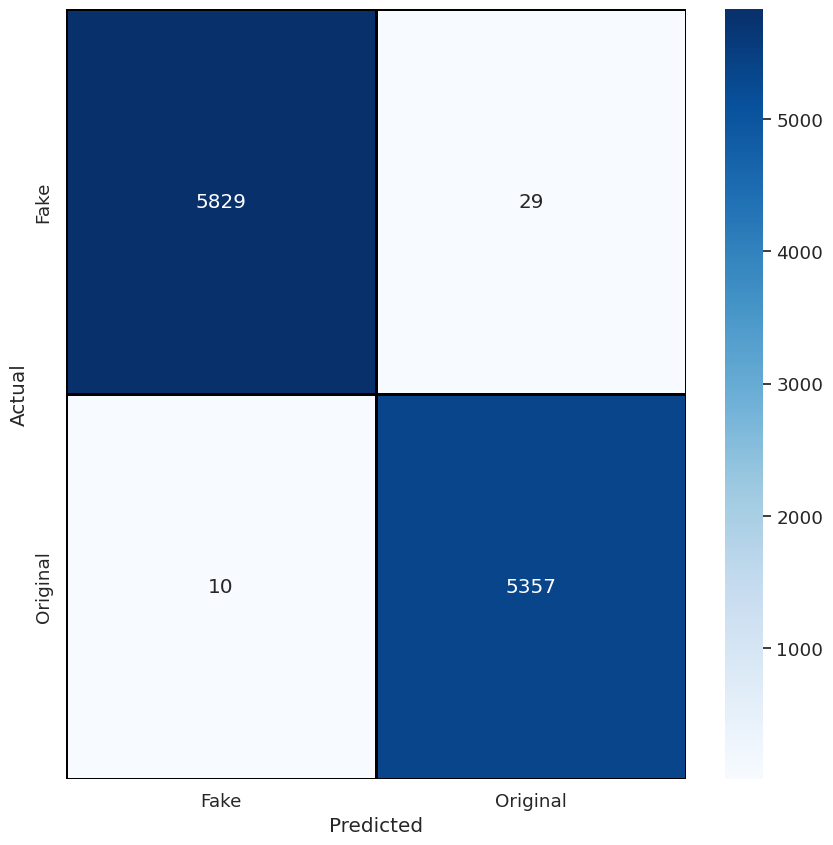

In [ ]:
#畫熱圖（heatmap），以視覺化方式更直觀地顯示混淆矩陣的結果。
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")